In [21]:
import torch
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from IPython.display import clear_output
from collections import Counter
from scipy.stats import kstest
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm

In [2]:
f = open('pi_dec_1m.txt','r')
big_string = f.read()
train_seq = big_string[2:100002]
test_seq = big_string[100002:200002]
len(train_seq), len(test_seq)

(100000, 100000)

## Модель - LSTM

In [63]:
from torch import nn
class LSTMs(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTMs, self).__init__()
        self.hidden_dim = hidden_dim

        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, num_layers=1).cuda()

        # The linear layer that maps from hidden state space to tag space
        self.hidden2linear = nn.Linear(100*hidden_dim, output_dim).cuda()
    

    def forward(self, digits, hidden=None):
        lstm_out, hidden = self.lstm(digits, hidden)
        
        out_flatten = lstm_out[:,:].reshape(lstm_out.size()[0], -1)
                
        digit_space = self.hidden2linear(out_flatten)
        digit_scores = F.log_softmax(digit_space, dim=1)
        return digit_scores, lstm_out
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(1, batch_size, self.hidden_dim).zero_().cuda(),
                      weight.new(1, batch_size, self.hidden_dim).zero_().cuda())
        return hidden

In [64]:
def str_seq_to_onehot_tensor(inp):
    s = len(inp)
    inp_b = np.array(list(map(int, inp)))
    b = np.zeros((s, 10))
    b[np.arange(s), inp_b] = 1
    return torch.from_numpy(b).type(torch.cuda.FloatTensor)#torch.FloatTensor)

In [65]:
from math import ceil

def batch_to_tensor(batch):
    
    tensor = torch.tensor(list(map(int, batch[0][:-1]))).type(torch.cuda.LongTensor)
    target = torch.tensor(int(batch[0][-1])).type(torch.cuda.LongTensor).view(-1,1)
    
    one_hot = torch.cuda.FloatTensor(tensor.size(0), 10).zero_()
    tensor = one_hot.scatter_(1, tensor.reshape(-1,1), 1)
    size = tensor.size()
    tensor = tensor.view(1, size[0], size[1])
        
    for b in batch[1:]:
        buf = torch.tensor(list(map(int, b[:-1]))).type(torch.cuda.LongTensor)
        
        one_hot = torch.cuda.FloatTensor(buf.size(0), 10).zero_()
        tensor = torch.cat((tensor, one_hot.scatter_(1, buf.reshape(-1,1), 1).view(1, size[0], size[1])), 0)
        target = torch.cat((target, torch.tensor(int(b[-1])).type(torch.cuda.LongTensor).view(-1,1)), 0)
                                                        
    return tensor, target.view(-1)

In [66]:
def new_batch_gen(seq, batch_size):
    x = [seq[i:i+101] for i in range(len(seq)-101)]
    for i in range(len(x)//batch_size):
        yield batch_to_tensor(x[batch_size*i : batch_size*(i+1)])

## Обучение модели

Epoch 99: Train_loss: 1.952130964499915, accuracy: 0.31218436873747496, LR: 0.0010416666666666669


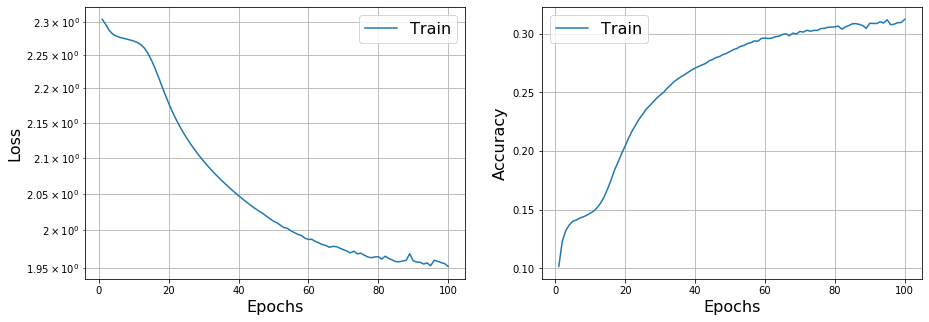

CPU times: user 44min 2s, sys: 47.6 s, total: 44min 50s
Wall time: 44min 33s


In [70]:
%%time

loss = nn.NLLLoss()
model = LSTMs(10, 50, 10)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=3, gamma=0.96)

losses = []
#ks_tests = []
accuracy = []
loss_test = []
EPOCHS = 100
BATCH_SIZE = 100

for epoch in range(EPOCHS):
    loss_epoch = []
    #ks_epoch = []
    accuracy_epoch = []
    size = 0
    for k, (X, y) in enumerate(new_batch_gen(train_seq, BATCH_SIZE)):
        size += len(X)
        model.zero_grad()
        prediction, h = model(X)  
        loss_batch = loss(prediction, y)
        
        
        loss_epoch.append(loss_batch.item()*len(X))
        buf = prediction.argmax(1).cpu().numpy()
        accuracy_epoch.append((buf==y.cpu().numpy()).mean()*len(X))
        
        print(f'\rEpoch {epoch+1}/{EPOCHS}:\tBatch {k+1}/{train_size//BATCH_SIZE},\t train_loss: {loss_epoch[-1]/len(X):.5f}',
              flush=True, end='')
        
        loss_batch.backward()
        optimizer.step()
            
    losses.append(np.sum(loss_epoch)/size)
    accuracy.append(np.sum(accuracy_epoch)/size)
    
    
    clear_output(True)
    
    print(f'Epoch {epoch}: Train_loss: {losses[-1]}, accuracy: {accuracy[-1]}, LR: {scheduler.get_lr()[0]}')#, ks_stat: {ks_tests[-1]}')#,  Test_loss: {loss_test[-1]}')
    
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.yscale('log')
    plt.plot(range(1, epoch+2), losses, label='Train')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid(which='both')
    
    plt.subplot(1, 2, 2)
    plt.yscale('linear')
    plt.plot(range(1, epoch+2), accuracy, label='Train')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Accuracy', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid(which='both')
    plt.show()

# Применение модели

In [ ]:
%%time 

s = 100
seq = str(test_seq)
sss = np.random.randint(len(seq)-100)
seed = seq[sss: sss+s]

rand = np.random.randint(0, 10, size=100)
seed = ''.join(rand.astype(str))

#seed = seq[sss: sss+s]

seed = train_seq[27000:27100] # <- из статьи

seed_init = str(seed)

# в начальный момент они совпадают с seed-последовательностью
inp = str(seed)
buf = str(seed)

X_inp = str_seq_to_onehot_tensor(inp).view(1, s, 10)

prns = []
preds = []

for i in tqdm(range(2600000)):
    
    # seed shift
    k, _ = model(X_inp)
    k = int(k.argmax(1))
    preds.append(k)
    
    sh = int(seed[k])
    
    seed = seed[sh:] + seed[:sh]
    
    r = int(seed[0])
    
    prns.append(r)
    
    # buffer sequence update
    buf += str(r)
    buf = buf[r:] + buf[:r]
    
    # input sequence 
    inp = buf[-s:]
    
    X_inp = str_seq_to_onehot_tensor(inp).view(1, s, 10)
    
prns = np.array(prns)
preds = np.array(preds)




  0%|          | 0/2600000 [00:00<?, ?it/s]


  0%|          | 52/2600000 [00:00<1:24:02, 515.63it/s]


  0%|          | 104/2600000 [00:00<1:24:09, 514.92it/s]


  0%|          | 156/2600000 [00:00<1:24:13, 514.49it/s]


  0%|          | 208/2600000 [00:00<1:24:14, 514.34it/s]


  0%|          | 260/2600000 [00:00<1:24:17, 514.08it/s]


  0%|          | 312/2600000 [00:00<1:24:18, 513.91it/s]


  0%|          | 364/2600000 [00:00<1:24:19, 513.80it/s]


  0%|          | 416/2600000 [00:00<1:24:20, 513.65it/s]


  0%|          | 468/2600000 [00:00<1:24:21, 513.54it/s]


  0%|          | 520/2600000 [00:01<1:24:22, 513.45it/s]


  0%|          | 570/2600000 [00:01<1:25:14, 508.23it/s]


  0%|          | 621/2600000 [00:01<1:25:09, 508.69it/s]


  0%|          | 673/2600000 [00:01<1:24:57, 509.93it/s]


  0%|          | 725/2600000 [00:01<1:24:45, 511.10it/s]


  0%|          | 777/2600000 [00:01<1:24:38, 511.77it/s]


  0%|          | 829/2600000 [00:01<1:24:33, 512.34it/s]


  0%|   

  0%|          | 6185/2600000 [00:12<1:24:12, 513.37it/s]


  0%|          | 6237/2600000 [00:12<1:24:13, 513.30it/s]


  0%|          | 6289/2600000 [00:12<1:24:12, 513.32it/s]


  0%|          | 6341/2600000 [00:12<1:24:11, 513.44it/s]


  0%|          | 6393/2600000 [00:12<1:24:11, 513.44it/s]


  0%|          | 6445/2600000 [00:12<1:24:11, 513.46it/s]


  0%|          | 6497/2600000 [00:12<1:24:09, 513.60it/s]


  0%|          | 6549/2600000 [00:12<1:24:10, 513.51it/s]


  0%|          | 6601/2600000 [00:12<1:24:11, 513.39it/s]


  0%|          | 6653/2600000 [00:12<1:24:11, 513.36it/s]


  0%|          | 6705/2600000 [00:13<1:24:12, 513.26it/s]


  0%|          | 6757/2600000 [00:13<1:24:12, 513.23it/s]


  0%|          | 6809/2600000 [00:13<1:24:11, 513.34it/s]


  0%|          | 6861/2600000 [00:13<1:24:12, 513.26it/s]


  0%|          | 6913/2600000 [00:13<1:24:14, 513.06it/s]


  0%|          | 6965/2600000 [00:13<1:24:13, 513.10it/s]


  0%|          | 7017/2600000 [00:13<1:2

  0%|          | 12321/2600000 [00:23<1:23:47, 514.66it/s]


  0%|          | 12373/2600000 [00:24<1:24:31, 510.25it/s]


  0%|          | 12425/2600000 [00:24<1:24:17, 511.60it/s]


  0%|          | 12477/2600000 [00:24<1:24:08, 512.49it/s]


  0%|          | 12529/2600000 [00:24<1:24:02, 513.11it/s]


  0%|          | 12581/2600000 [00:24<1:23:59, 513.45it/s]


  0%|          | 12633/2600000 [00:24<1:23:57, 513.67it/s]


  0%|          | 12685/2600000 [00:24<1:23:55, 513.83it/s]


  0%|          | 12737/2600000 [00:24<1:23:52, 514.13it/s]


  0%|          | 12789/2600000 [00:24<1:23:50, 514.30it/s]


  0%|          | 12841/2600000 [00:24<1:23:48, 514.49it/s]


  0%|          | 12893/2600000 [00:25<1:23:47, 514.61it/s]


  0%|          | 12945/2600000 [00:25<1:23:46, 514.69it/s]


  0%|          | 12997/2600000 [00:25<1:23:45, 514.78it/s]


  1%|          | 13049/2600000 [00:25<1:23:45, 514.81it/s]


  1%|          | 13101/2600000 [00:25<1:23:44, 514.83it/s]


  1%|          | 13153/2

  1%|          | 18405/2600000 [00:35<1:23:35, 514.76it/s]


  1%|          | 18457/2600000 [00:35<1:23:36, 514.57it/s]


  1%|          | 18509/2600000 [00:36<1:23:37, 514.54it/s]


  1%|          | 18561/2600000 [00:36<1:23:37, 514.52it/s]


  1%|          | 18613/2600000 [00:36<1:23:37, 514.47it/s]


  1%|          | 18665/2600000 [00:36<1:23:37, 514.42it/s]


  1%|          | 18717/2600000 [00:36<1:23:38, 514.38it/s]


  1%|          | 18769/2600000 [00:36<1:23:38, 514.31it/s]


  1%|          | 18821/2600000 [00:36<1:23:37, 514.40it/s]


  1%|          | 18873/2600000 [00:36<1:23:37, 514.43it/s]


  1%|          | 18925/2600000 [00:36<1:23:37, 514.38it/s]


  1%|          | 18977/2600000 [00:36<1:23:37, 514.44it/s]


  1%|          | 19029/2600000 [00:37<1:23:36, 514.46it/s]


  1%|          | 19081/2600000 [00:37<1:23:35, 514.54it/s]


  1%|          | 19133/2600000 [00:37<1:23:34, 514.66it/s]


  1%|          | 19185/2600000 [00:37<1:23:34, 514.71it/s]


  1%|          | 19237/2

  1%|          | 24489/2600000 [00:47<1:23:35, 513.50it/s]


  1%|          | 24541/2600000 [00:47<1:23:32, 513.80it/s]


  1%|          | 24593/2600000 [00:47<1:23:30, 514.05it/s]


  1%|          | 24645/2600000 [00:47<1:23:29, 514.10it/s]


  1%|          | 24697/2600000 [00:48<1:23:28, 514.21it/s]


  1%|          | 24749/2600000 [00:48<1:23:28, 514.21it/s]


  1%|          | 24801/2600000 [00:48<1:23:27, 514.25it/s]


  1%|          | 24853/2600000 [00:48<1:23:27, 514.24it/s]


  1%|          | 24905/2600000 [00:48<1:23:27, 514.29it/s]


  1%|          | 24957/2600000 [00:48<1:23:26, 514.32it/s]


  1%|          | 25009/2600000 [00:48<1:23:26, 514.37it/s]


  1%|          | 25061/2600000 [00:48<1:23:26, 514.37it/s]


  1%|          | 25113/2600000 [00:48<1:23:26, 514.34it/s]


  1%|          | 25165/2600000 [00:48<1:23:25, 514.37it/s]


  1%|          | 25217/2600000 [00:49<1:23:25, 514.43it/s]


  1%|          | 25269/2600000 [00:49<1:23:25, 514.39it/s]


  1%|          | 25321/2

  1%|          | 30573/2600000 [00:59<1:23:10, 514.81it/s]


  1%|          | 30625/2600000 [00:59<1:23:12, 514.69it/s]


  1%|          | 30677/2600000 [00:59<1:23:12, 514.59it/s]


  1%|          | 30729/2600000 [00:59<1:23:12, 514.65it/s]


  1%|          | 30781/2600000 [00:59<1:23:11, 514.72it/s]


  1%|          | 30833/2600000 [00:59<1:23:11, 514.75it/s]


  1%|          | 30885/2600000 [01:00<1:23:11, 514.73it/s]


  1%|          | 30937/2600000 [01:00<1:23:11, 514.67it/s]


  1%|          | 30989/2600000 [01:00<1:23:12, 514.58it/s]


  1%|          | 31041/2600000 [01:00<1:23:12, 514.54it/s]


  1%|          | 31093/2600000 [01:00<1:23:13, 514.44it/s]


  1%|          | 31145/2600000 [01:00<1:23:12, 514.59it/s]


  1%|          | 31197/2600000 [01:00<1:23:12, 514.56it/s]


  1%|          | 31249/2600000 [01:00<1:23:11, 514.63it/s]


  1%|          | 31301/2600000 [01:00<1:23:11, 514.62it/s]


  1%|          | 31353/2600000 [01:00<1:23:11, 514.61it/s]


  1%|          | 31405/2

  1%|▏         | 36657/2600000 [01:11<1:23:00, 514.71it/s]


  1%|▏         | 36709/2600000 [01:11<1:22:59, 514.72it/s]


  1%|▏         | 36761/2600000 [01:11<1:22:57, 514.91it/s]


  1%|▏         | 36813/2600000 [01:11<1:22:57, 514.95it/s]


  1%|▏         | 36865/2600000 [01:11<1:22:57, 514.92it/s]


  1%|▏         | 36917/2600000 [01:11<1:22:59, 514.70it/s]


  1%|▏         | 36969/2600000 [01:11<1:22:59, 514.68it/s]


  1%|▏         | 37021/2600000 [01:12<1:23:00, 514.64it/s]


  1%|▏         | 37073/2600000 [01:12<1:23:01, 514.51it/s]


  1%|▏         | 37125/2600000 [01:12<1:23:01, 514.49it/s]


  1%|▏         | 37177/2600000 [01:12<1:23:00, 514.62it/s]


  1%|▏         | 37229/2600000 [01:12<1:22:58, 514.72it/s]


  1%|▏         | 37281/2600000 [01:12<1:22:58, 514.74it/s]


  1%|▏         | 37333/2600000 [01:12<1:22:58, 514.71it/s]


  1%|▏         | 37385/2600000 [01:12<1:22:58, 514.74it/s]


  1%|▏         | 37437/2600000 [01:12<1:22:58, 514.69it/s]


  1%|▏         | 37489/2

  2%|▏         | 42741/2600000 [01:23<1:22:49, 514.64it/s]


  2%|▏         | 42793/2600000 [01:23<1:22:48, 514.65it/s]


  2%|▏         | 42845/2600000 [01:23<1:22:48, 514.70it/s]


  2%|▏         | 42897/2600000 [01:23<1:22:47, 514.74it/s]


  2%|▏         | 42949/2600000 [01:23<1:22:47, 514.71it/s]


  2%|▏         | 43001/2600000 [01:23<1:22:47, 514.73it/s]


  2%|▏         | 43053/2600000 [01:23<1:22:48, 514.60it/s]


  2%|▏         | 43105/2600000 [01:23<1:22:49, 514.55it/s]


  2%|▏         | 43157/2600000 [01:23<1:22:49, 514.50it/s]


  2%|▏         | 43209/2600000 [01:24<1:22:49, 514.46it/s]


  2%|▏         | 43261/2600000 [01:24<1:22:51, 514.26it/s]


  2%|▏         | 43313/2600000 [01:24<1:22:52, 514.14it/s]


  2%|▏         | 43365/2600000 [01:24<1:22:52, 514.11it/s]


  2%|▏         | 43417/2600000 [01:24<1:22:52, 514.10it/s]


  2%|▏         | 43469/2600000 [01:24<1:22:52, 514.09it/s]


  2%|▏         | 43521/2600000 [01:24<1:22:52, 514.16it/s]


  2%|▏         | 43573/2

  2%|▏         | 48825/2600000 [01:34<1:22:43, 513.99it/s]


  2%|▏         | 48877/2600000 [01:35<1:22:42, 514.13it/s]


  2%|▏         | 48929/2600000 [01:35<1:22:41, 514.15it/s]


  2%|▏         | 48981/2600000 [01:35<1:22:40, 514.25it/s]


  2%|▏         | 49033/2600000 [01:35<1:22:39, 514.31it/s]


  2%|▏         | 49085/2600000 [01:35<1:22:39, 514.36it/s]


  2%|▏         | 49137/2600000 [01:35<1:22:39, 514.38it/s]


  2%|▏         | 49189/2600000 [01:35<1:22:38, 514.43it/s]


  2%|▏         | 49241/2600000 [01:35<1:22:39, 514.33it/s]


  2%|▏         | 49293/2600000 [01:35<1:22:38, 514.44it/s]


  2%|▏         | 49345/2600000 [01:35<1:22:38, 514.41it/s]


  2%|▏         | 49397/2600000 [01:36<1:22:39, 514.25it/s]


  2%|▏         | 49449/2600000 [01:36<1:22:39, 514.28it/s]


  2%|▏         | 49501/2600000 [01:36<1:22:39, 514.25it/s]


  2%|▏         | 49553/2600000 [01:36<1:22:39, 514.20it/s]


  2%|▏         | 49605/2600000 [01:36<1:22:40, 514.12it/s]


  2%|▏         | 49657/2

  2%|▏         | 54909/2600000 [01:46<1:22:27, 514.43it/s]


  2%|▏         | 54961/2600000 [01:46<1:22:27, 514.43it/s]


  2%|▏         | 55013/2600000 [01:47<1:22:27, 514.44it/s]


  2%|▏         | 55065/2600000 [01:47<1:22:27, 514.44it/s]


  2%|▏         | 55117/2600000 [01:47<1:22:27, 514.33it/s]


  2%|▏         | 55169/2600000 [01:47<1:22:28, 514.29it/s]


  2%|▏         | 55221/2600000 [01:47<1:22:27, 514.36it/s]


  2%|▏         | 55273/2600000 [01:47<1:22:27, 514.35it/s]


  2%|▏         | 55325/2600000 [01:47<1:22:29, 514.13it/s]


  2%|▏         | 55377/2600000 [01:47<1:22:30, 514.06it/s]


  2%|▏         | 55429/2600000 [01:47<1:22:30, 514.01it/s]


  2%|▏         | 55481/2600000 [01:47<1:22:29, 514.10it/s]


  2%|▏         | 55533/2600000 [01:48<1:22:30, 514.01it/s]


  2%|▏         | 55585/2600000 [01:48<1:22:30, 513.97it/s]


  2%|▏         | 55637/2600000 [01:48<1:23:15, 509.38it/s]


  2%|▏         | 55689/2600000 [01:48<1:23:11, 509.76it/s]


  2%|▏         | 55741/2

  2%|▏         | 60993/2600000 [01:58<1:22:20, 513.91it/s]


  2%|▏         | 61045/2600000 [01:58<1:22:20, 513.87it/s]


  2%|▏         | 61097/2600000 [01:58<1:22:19, 513.97it/s]


  2%|▏         | 61149/2600000 [01:58<1:22:19, 513.97it/s]


  2%|▏         | 61201/2600000 [01:59<1:22:18, 514.04it/s]


  2%|▏         | 61253/2600000 [01:59<1:22:18, 514.03it/s]


  2%|▏         | 61305/2600000 [01:59<1:22:19, 513.94it/s]


  2%|▏         | 61357/2600000 [01:59<1:22:20, 513.89it/s]


  2%|▏         | 61409/2600000 [01:59<1:22:20, 513.81it/s]


  2%|▏         | 61461/2600000 [01:59<1:22:21, 513.69it/s]


  2%|▏         | 61513/2600000 [01:59<1:22:21, 513.66it/s]


  2%|▏         | 61565/2600000 [01:59<1:22:22, 513.57it/s]


  2%|▏         | 61617/2600000 [01:59<1:22:23, 513.51it/s]


  2%|▏         | 61669/2600000 [01:59<1:22:22, 513.56it/s]


  2%|▏         | 61721/2600000 [02:00<1:22:23, 513.46it/s]


  2%|▏         | 61773/2600000 [02:00<1:22:23, 513.47it/s]


  2%|▏         | 61825/2

  3%|▎         | 67077/2600000 [02:10<1:22:13, 513.43it/s]


  3%|▎         | 67129/2600000 [02:10<1:22:12, 513.52it/s]


  3%|▎         | 67181/2600000 [02:10<1:22:12, 513.54it/s]


  3%|▎         | 67233/2600000 [02:10<1:22:12, 513.48it/s]


  3%|▎         | 67285/2600000 [02:10<1:22:10, 513.69it/s]


  3%|▎         | 67337/2600000 [02:10<1:22:09, 513.81it/s]


  3%|▎         | 67389/2600000 [02:11<1:22:52, 509.34it/s]


  3%|▎         | 67441/2600000 [02:11<1:22:39, 510.60it/s]


  3%|▎         | 67493/2600000 [02:11<1:22:30, 511.60it/s]


  3%|▎         | 67545/2600000 [02:11<1:22:21, 512.46it/s]


  3%|▎         | 67597/2600000 [02:11<1:22:17, 512.92it/s]


  3%|▎         | 67649/2600000 [02:11<1:22:14, 513.23it/s]


  3%|▎         | 67701/2600000 [02:11<1:22:11, 513.47it/s]


  3%|▎         | 67753/2600000 [02:11<1:22:09, 513.69it/s]


  3%|▎         | 67805/2600000 [02:11<1:22:09, 513.68it/s]


  3%|▎         | 67857/2600000 [02:12<1:22:08, 513.80it/s]


  3%|▎         | 67909/2

  3%|▎         | 73161/2600000 [02:22<1:22:03, 513.26it/s]


  3%|▎         | 73213/2600000 [02:22<1:22:03, 513.24it/s]


  3%|▎         | 73265/2600000 [02:22<1:22:02, 513.34it/s]


  3%|▎         | 73317/2600000 [02:22<1:22:03, 513.22it/s]


  3%|▎         | 73369/2600000 [02:22<1:22:02, 513.26it/s]


  3%|▎         | 73421/2600000 [02:22<1:22:02, 513.30it/s]


  3%|▎         | 73473/2600000 [02:22<1:22:01, 513.34it/s]


  3%|▎         | 73525/2600000 [02:23<1:22:01, 513.37it/s]


  3%|▎         | 73577/2600000 [02:23<1:22:00, 513.45it/s]


  3%|▎         | 73629/2600000 [02:23<1:21:59, 513.51it/s]


  3%|▎         | 73681/2600000 [02:23<1:22:00, 513.47it/s]


  3%|▎         | 73733/2600000 [02:23<1:21:59, 513.52it/s]


  3%|▎         | 73785/2600000 [02:23<1:21:58, 513.58it/s]


  3%|▎         | 73837/2600000 [02:23<1:21:58, 513.62it/s]


  3%|▎         | 73889/2600000 [02:23<1:21:58, 513.56it/s]


  3%|▎         | 73941/2600000 [02:23<1:21:58, 513.58it/s]


  3%|▎         | 73993/2

  3%|▎         | 79245/2600000 [02:34<1:22:41, 508.01it/s]


  3%|▎         | 79297/2600000 [02:34<1:22:29, 509.26it/s]


  3%|▎         | 79349/2600000 [02:34<1:22:19, 510.27it/s]


  3%|▎         | 79401/2600000 [02:34<1:22:13, 510.96it/s]


  3%|▎         | 79453/2600000 [02:34<1:22:06, 511.65it/s]


  3%|▎         | 79505/2600000 [02:34<1:22:02, 512.03it/s]


  3%|▎         | 79557/2600000 [02:34<1:22:00, 512.24it/s]


  3%|▎         | 79609/2600000 [02:34<1:21:57, 512.50it/s]


  3%|▎         | 79661/2600000 [02:35<1:21:54, 512.82it/s]


  3%|▎         | 79713/2600000 [02:35<1:21:54, 512.80it/s]


  3%|▎         | 79765/2600000 [02:35<1:21:53, 512.93it/s]


  3%|▎         | 79817/2600000 [02:35<1:21:51, 513.13it/s]


  3%|▎         | 79869/2600000 [02:35<1:21:50, 513.20it/s]


  3%|▎         | 79921/2600000 [02:35<1:21:50, 513.23it/s]


  3%|▎         | 79973/2600000 [02:35<1:21:48, 513.37it/s]


  3%|▎         | 80025/2600000 [02:35<1:21:48, 513.36it/s]


  3%|▎         | 80077/2

  3%|▎         | 85328/2600000 [02:46<1:21:40, 513.15it/s]


  3%|▎         | 85380/2600000 [02:46<1:21:40, 513.15it/s]


  3%|▎         | 85432/2600000 [02:46<1:21:39, 513.26it/s]


  3%|▎         | 85484/2600000 [02:46<1:21:39, 513.18it/s]


  3%|▎         | 85536/2600000 [02:46<1:21:39, 513.16it/s]


  3%|▎         | 85588/2600000 [02:46<1:21:40, 513.10it/s]


  3%|▎         | 85640/2600000 [02:46<1:21:39, 513.14it/s]


  3%|▎         | 85692/2600000 [02:46<1:21:39, 513.18it/s]


  3%|▎         | 85744/2600000 [02:46<1:21:40, 513.08it/s]


  3%|▎         | 85796/2600000 [02:46<1:21:42, 512.84it/s]


  3%|▎         | 85848/2600000 [02:47<1:21:46, 512.41it/s]


  3%|▎         | 85900/2600000 [02:47<1:21:45, 512.47it/s]


  3%|▎         | 85952/2600000 [02:47<1:21:46, 512.44it/s]


  3%|▎         | 86004/2600000 [02:47<1:21:46, 512.35it/s]


  3%|▎         | 86056/2600000 [02:47<1:21:46, 512.36it/s]


  3%|▎         | 86108/2600000 [02:47<1:21:46, 512.35it/s]


  3%|▎         | 86160/2

  4%|▎         | 91412/2600000 [02:57<1:21:30, 512.95it/s]


  4%|▎         | 91464/2600000 [02:58<1:21:29, 513.01it/s]


  4%|▎         | 91516/2600000 [02:58<1:21:27, 513.24it/s]


  4%|▎         | 91568/2600000 [02:58<1:21:26, 513.30it/s]


  4%|▎         | 91620/2600000 [02:58<1:21:39, 511.92it/s]


  4%|▎         | 91672/2600000 [02:58<1:21:35, 512.37it/s]


  4%|▎         | 91724/2600000 [02:58<1:21:31, 512.78it/s]


  4%|▎         | 91776/2600000 [02:58<1:21:29, 512.96it/s]


  4%|▎         | 91828/2600000 [02:58<1:21:27, 513.22it/s]


  4%|▎         | 91880/2600000 [02:58<1:21:27, 513.22it/s]


  4%|▎         | 91932/2600000 [02:58<1:21:27, 513.19it/s]


  4%|▎         | 91984/2600000 [02:59<1:21:27, 513.18it/s]


  4%|▎         | 92036/2600000 [02:59<1:21:27, 513.10it/s]


  4%|▎         | 92088/2600000 [02:59<1:21:28, 513.07it/s]


  4%|▎         | 92140/2600000 [02:59<1:21:27, 513.08it/s]


  4%|▎         | 92192/2600000 [02:59<1:21:31, 512.73it/s]


  4%|▎         | 92244/2

  4%|▎         | 97496/2600000 [03:09<1:21:22, 512.50it/s]


  4%|▍         | 97548/2600000 [03:09<1:21:21, 512.63it/s]


  4%|▍         | 97600/2600000 [03:09<1:21:21, 512.59it/s]


  4%|▍         | 97652/2600000 [03:10<1:21:22, 512.51it/s]


  4%|▍         | 97704/2600000 [03:10<1:21:21, 512.60it/s]


  4%|▍         | 97756/2600000 [03:10<1:21:19, 512.77it/s]


  4%|▍         | 97808/2600000 [03:10<1:21:22, 512.53it/s]


  4%|▍         | 97860/2600000 [03:10<1:21:19, 512.74it/s]


  4%|▍         | 97912/2600000 [03:10<1:21:18, 512.92it/s]


  4%|▍         | 97964/2600000 [03:10<1:21:17, 513.00it/s]


  4%|▍         | 98016/2600000 [03:10<1:21:16, 513.08it/s]


  4%|▍         | 98068/2600000 [03:10<1:21:16, 513.04it/s]


  4%|▍         | 98120/2600000 [03:11<1:21:16, 513.09it/s]


  4%|▍         | 98172/2600000 [03:11<1:21:15, 513.12it/s]


  4%|▍         | 98224/2600000 [03:11<1:21:16, 513.07it/s]


  4%|▍         | 98276/2600000 [03:11<1:21:15, 513.16it/s]


  4%|▍         | 98328/2

  4%|▍         | 103528/2600000 [03:21<1:21:11, 512.42it/s]


  4%|▍         | 103580/2600000 [03:21<1:21:12, 512.33it/s]


  4%|▍         | 103632/2600000 [03:21<1:21:17, 511.86it/s]


  4%|▍         | 103684/2600000 [03:21<1:21:13, 512.18it/s]


  4%|▍         | 103736/2600000 [03:21<1:21:13, 512.16it/s]


  4%|▍         | 103788/2600000 [03:22<1:21:14, 512.15it/s]


  4%|▍         | 103840/2600000 [03:22<1:21:13, 512.18it/s]


  4%|▍         | 103892/2600000 [03:22<1:21:13, 512.18it/s]


  4%|▍         | 103944/2600000 [03:22<1:21:11, 512.35it/s]


  4%|▍         | 103996/2600000 [03:22<1:21:11, 512.35it/s]


  4%|▍         | 104048/2600000 [03:22<1:21:11, 512.31it/s]


  4%|▍         | 104100/2600000 [03:22<1:21:12, 512.28it/s]


  4%|▍         | 104152/2600000 [03:22<1:21:09, 512.55it/s]


  4%|▍         | 104204/2600000 [03:22<1:21:07, 512.74it/s]


  4%|▍         | 104256/2600000 [03:22<1:21:06, 512.82it/s]


  4%|▍         | 104308/2600000 [03:23<1:21:06, 512.83it/s]


  4%|▍  

  4%|▍         | 109508/2600000 [03:33<1:20:56, 512.85it/s]


  4%|▍         | 109560/2600000 [03:33<1:20:57, 512.69it/s]


  4%|▍         | 109612/2600000 [03:33<1:20:56, 512.80it/s]


  4%|▍         | 109664/2600000 [03:33<1:20:55, 512.85it/s]


  4%|▍         | 109716/2600000 [03:33<1:20:58, 512.51it/s]


  4%|▍         | 109768/2600000 [03:33<1:20:57, 512.62it/s]


  4%|▍         | 109820/2600000 [03:33<1:20:57, 512.61it/s]


  4%|▍         | 109872/2600000 [03:33<1:20:59, 512.42it/s]


  4%|▍         | 109924/2600000 [03:34<1:21:04, 511.91it/s]


  4%|▍         | 109976/2600000 [03:34<1:21:03, 512.01it/s]


  4%|▍         | 110028/2600000 [03:34<1:21:02, 512.11it/s]


  4%|▍         | 110080/2600000 [03:34<1:21:02, 512.12it/s]


  4%|▍         | 110132/2600000 [03:34<1:21:01, 512.16it/s]


  4%|▍         | 110184/2600000 [03:34<1:21:01, 512.13it/s]


  4%|▍         | 110236/2600000 [03:34<1:20:59, 512.31it/s]


  4%|▍         | 110288/2600000 [03:34<1:21:00, 512.24it/s]


  4%|▍  

  4%|▍         | 115455/2600000 [03:44<1:21:01, 511.07it/s]


  4%|▍         | 115507/2600000 [03:45<1:20:57, 511.44it/s]


  4%|▍         | 115559/2600000 [03:45<1:20:55, 511.70it/s]


  4%|▍         | 115611/2600000 [03:45<1:20:53, 511.86it/s]


  4%|▍         | 115663/2600000 [03:45<1:20:53, 511.92it/s]


  4%|▍         | 115715/2600000 [03:45<1:20:51, 512.02it/s]


  4%|▍         | 115767/2600000 [03:45<1:20:51, 512.01it/s]


  4%|▍         | 115819/2600000 [03:45<1:20:51, 512.05it/s]


  4%|▍         | 115871/2600000 [03:45<1:20:50, 512.10it/s]


  4%|▍         | 115923/2600000 [03:45<1:20:51, 512.05it/s]


  4%|▍         | 115975/2600000 [03:45<1:20:54, 511.67it/s]


  4%|▍         | 116027/2600000 [03:46<1:20:52, 511.86it/s]


  4%|▍         | 116079/2600000 [03:46<1:20:52, 511.84it/s]


  4%|▍         | 116131/2600000 [03:46<1:20:51, 511.93it/s]


  4%|▍         | 116183/2600000 [03:46<1:20:54, 511.69it/s]


  4%|▍         | 116235/2600000 [03:46<1:20:51, 511.92it/s]


  4%|▍  

  5%|▍         | 121435/2600000 [03:56<1:20:43, 511.75it/s]


  5%|▍         | 121487/2600000 [03:56<1:20:41, 511.94it/s]


  5%|▍         | 121539/2600000 [03:56<1:20:40, 511.99it/s]


  5%|▍         | 121591/2600000 [03:56<1:20:40, 511.98it/s]


  5%|▍         | 121643/2600000 [03:57<1:20:40, 511.96it/s]


  5%|▍         | 121695/2600000 [03:57<1:20:44, 511.61it/s]


  5%|▍         | 121747/2600000 [03:57<1:20:45, 511.43it/s]


  5%|▍         | 121799/2600000 [03:57<1:20:44, 511.51it/s]


  5%|▍         | 121851/2600000 [03:57<1:20:44, 511.52it/s]


  5%|▍         | 121903/2600000 [03:57<1:20:42, 511.73it/s]


  5%|▍         | 121955/2600000 [03:57<1:20:40, 511.89it/s]


  5%|▍         | 122007/2600000 [03:57<1:20:41, 511.85it/s]


  5%|▍         | 122059/2600000 [03:57<1:20:40, 511.91it/s]


  5%|▍         | 122111/2600000 [03:57<1:20:42, 511.69it/s]


  5%|▍         | 122163/2600000 [03:58<1:20:43, 511.62it/s]


  5%|▍         | 122215/2600000 [03:58<1:20:43, 511.55it/s]

## Посмотрим на распределение

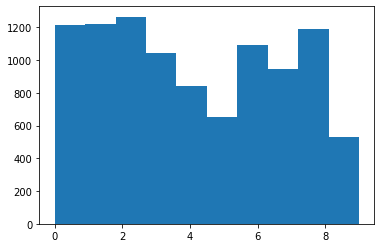

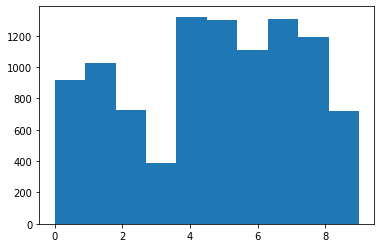

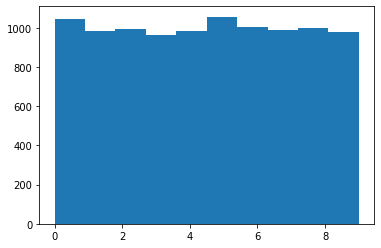

In [39]:
plt.hist(prns)
plt.show()
plt.hist(preds)
plt.show()

plt.hist(list(map(int,seq[:10000])))
plt.show()

## Посмотрим на встроенные тесты, например, на равномерность

In [31]:
kstest(prns/10, 'uniform'), kstest(preds/10, 'uniform'), kstest(np.random.rand(100), 'uniform')

(KstestResult(statistic=0.17669615384615384, pvalue=0.0),
 KstestResult(statistic=0.11986307692307685, pvalue=0.0),
 KstestResult(statistic=0.08055275540966611, pvalue=0.5182320207778532))

12970094966974458054
72886936310203678232
50182323708459790111
54847208761821247781
32663304120762165873
[11 11 13 10  9  6 10 12 11  7]


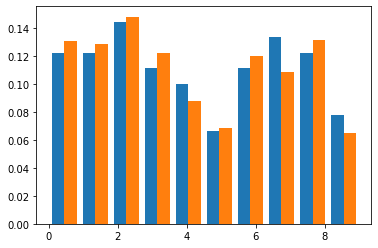

In [32]:
print('\n'.join([seed[20*i:20*i+20] for i in range(5)]))
print(np.bincount(list(map(int, seed))))
plt.hist([list(map(int,seed)), prns],density=True, bins=10)
plt.show()

In [40]:
from scipy.stats import chisquare

In [41]:
chisquare(np.bincount(list(map(int, seed)))*(len(prns)//100), np.bincount(prns))

Power_divergenceResult(statistic=169.5816240938583, pvalue=7.541848251254894e-32)

## Сохранение 


In [37]:
f = open('2.6_millon.txt', 'w')
f.write('\n'.join(preds.astype(str)))

5199999

In [42]:
np.bincount(prns)

array([1215, 1221, 1265, 1046,  842,  655, 1091,  945, 1187,  533])